# Installing libraries

In [ ]:
import sys
on_colab = 'google.colab' in sys.modules
if on_colab:
  !pip install --upgrade pip
  # !pip install torchvision torchaudio
  !pip install icecream
  !pip install --upgrade diffusers transformers accelerate

# Dataset Download

## Emotic Dataset

In [ ]:
from pathlib import Path
data_root = Path("dataset")
data_exist = Path(data_root).exists()

In [ ]:
if on_colab and not data_exist:
  !mkdir -p dataset
  # !sudo mount -t tmpfs -o size=7G ramdisk dataset

  !cp drive/MyDrive/emotic.zip dataset/ ## Requires you to add a shortcut to the emotics dataset into your drive
  !cd dataset/; unzip emotic.zip
  !rm -rf dataset/emotic.zip

## IMEMNet

In [ ]:
if not data_exist:
  !cd dataset/; git clone https://github.com/linkAmy/IMEMNet.git

## DEAM

In [ ]:
if not data_exist:
  !cd dataset/; wget http://cvml.unige.ch/databases/DEAM/DEAM_audio.zip
  !cd dataset/; unzip DEAM_audio.zip
  !rm -rf dataset/DEAM_audio.zip

# Dataset Preprocessing

In [ ]:
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
import random
import math

class ThreadDataLoader():
  def __init__(self, dataset, batch_size = 1, shuffle = False, num_workers = 2, look_ahead = 2):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.num_workers = num_workers
    self.look_ahead = look_ahead

  def __getitem__(self, idx):
    return self.dataset[idx]

  def __len__(self):
    return math.ceil(len(self.dataset) / self.batch_size)

  def __iter__(self):
    executor = PoolExecutor(max_workers=self.num_workers)
    idxs = list(range(len(self.dataset)))
    if self.shuffle:
      random.shuffle(idxs)
    look_ahead = self.look_ahead * max(self.batch_size, self.num_workers)
    futures = {i: executor.submit(ThreadDataLoader.__getitem__, self, i) for i in idxs[:look_ahead]}
    collated_arr = []
    for i, idx in enumerate(idxs):
      data = futures[idx].result()
      del futures[idx]
      if i + look_ahead < len(idxs):
        futures[idxs[i + look_ahead]] = executor.submit(ThreadDataLoader.__getitem__, self, idxs[i + look_ahead])
      collated_arr.append(data)
      collated_batch = []
      if len(collated_arr) == self.batch_size:
          collated_batch = [torch.stack(data) for data in zip(*collated_arr)]
          yield collated_batch
          collated_arr = []
    if len(collated_arr) > 0:
      collated_batch = [torch.stack(data) for data in zip(*collated_arr)]
      yield collated_batch

In [ ]:
import torch
from torch.utils.data import Dataset
import torchaudio as TA
import torchvision as TV

from pathlib import Path

import polars as pl
from icecream import ic

import torch.nn as nn
import torchaudio.transforms as TAT
import torchvision
import torchvision.transforms.v2 as TVT

import PIL

class WaveformProcessing(nn.Module):
  def __init__(self):
    super().__init__()

    self.mel_fn = TAT.MelSpectrogram(
        sample_rate = 16000,
        n_fft = 1024,
        win_length = 1024,
        hop_length = 160 // 2,
        f_min = 0,
        f_max = 8000,
        n_mels = 64,
    )

  def forward(self, waveform):
    return self.mel_fn(waveform)

class IMEM(Dataset):
  def __init__(self, data_root = Path("dataset"), split="train",
               image_transform = None, audio_transform = None):
    self.image_transform = image_transform
    self.audio_transform = audio_transform
    self.data_root = data_root
    self.imemnet_root = data_root / "IMEMNet"
    self.deam_root = data_root / "MEMD_audio"
    self.emotic_root = data_root / "emotic"

    df = pl.read_csv(self.imemnet_root / f"{split}_matching.txt", has_header=False, separator=' ',
          new_columns = ["music_clip_id", "image_id", "matching_score"])

    df = df.with_columns([pl.col("music_clip_id").str.split_exact("-", 1).struct.rename_fields(["music_clip_path", "music_clip_segment"]).alias("fields")]).unnest("fields")
    # ic(df["music_clip_segment"].cast(pl.Int32).max(), df["music_clip_segment"].cast(pl.Int32).min())

    music_path_map = {music_path.stem: str(music_path) for music_path in self.deam_root.rglob("*.mp3")}
    df = df.with_columns(music_clip_path=pl.col("music_clip_path").replace(music_path_map))

    image_path_map = {image_path.stem: str(image_path) for image_path in self.emotic_root.rglob("*.jpg")}
    df = df.with_columns(image_path=pl.col("image_id").replace(image_path_map, default=None))

    df = df.drop_nulls()

    # self.music_clips = {music_clip_path:TA.load(music_clip_path, frame_offset=int((15 - 2) * 44100))[0] for music_clip_path in df["music_clip_path"].unique()}

    self.df = df

  def __getitem__(self, idx):
    df = dict(zip(self.df.columns, self.df.row(idx)))

    # image = TV.io.read_image(df["image_path"])[:3, ...]
    image = PIL.Image.open(df["image_path"]).convert("RGB")
    # if image.shape[0] == 1:
    #   image = image.repeat(3, 1, 1)
    if self.image_transform is not None:
      image = self.image_transform(image)

    music_clip_segment = int(df["music_clip_segment"])

    SAMPLE_RATE = TA.info(df["music_clip_path"]).sample_rate

    start_frame = int((music_clip_segment * 2 - 2) * SAMPLE_RATE)
    music_clip, sr = TA.load(df["music_clip_path"],
                         frame_offset = start_frame,
                         num_frames=int(2 * SAMPLE_RATE),
                         buffer_size=int(2 * SAMPLE_RATE))
    music_clip = TA.functional.resample(music_clip, SAMPLE_RATE, 16000)
    if music_clip.shape[-1] == 0:
      ic(df["music_clip_path"], music_clip_segment)
    # music_clip = self.music_clips[df["music_clip_path"]][:, start_frame:start_frame+int(2 * SAMPLE_RATE)]

    music_clip = music_clip.mean(0, keepdim=True)
    if self.audio_transform is not None:
      music_clip = self.audio_transform(music_clip)

    distance = torch.tensor(df["matching_score"], dtype=torch.float)

    # ic(image.shape, music_clip.shape, distance)

    return image, music_clip, distance

  def __len__(self):
    return len(self.df)

class IMEM_Grouped(Dataset):
  def __init__(self, data_root = Path("dataset"), split="train",
               image_transform = None, audio_transform = None):
    self.image_transform = image_transform
    self.audio_transform = audio_transform
    self.data_root = data_root
    self.imemnet_root = data_root / "IMEMNet"
    self.deam_root = data_root / "MEMD_audio"
    self.emotic_root = data_root / "emotic"

    df = pl.read_csv(self.imemnet_root / f"{split}_matching.txt", has_header=False, separator=' ',
          new_columns = ["music_clip_id", "image_id", "matching_score"])

    df = df.with_columns([pl.col("music_clip_id").str.split_exact("-", 1).struct.rename_fields(["music_clip_path", "music_clip_segment"]).alias("fields")]).unnest("fields")

    music_path_map = {music_path.stem: str(music_path) for music_path in self.deam_root.rglob("*.mp3")}
    df = df.with_columns(music_clip_path=pl.col("music_clip_path").replace(music_path_map))

    image_path_map = {image_path.stem: str(image_path) for image_path in self.emotic_root.rglob("*.jpg")}
    df = df.with_columns(image_path=pl.col("image_id").replace(image_path_map, default=None))

    df = df.drop_nulls()

    self.image_ids = df.group_by(pl.col("image_id")).len().filter(pl.col("len") >= 3)["image_id"]

    self.df = df

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    df_image_id = self.df.filter(pl.col("image_id") == image_id)

    image = PIL.Image.open(df_image_id["image_path"][0]).convert("RGB")
    if self.image_transform is not None:
      image = self.image_transform(image)

    music_clips = []
    distances = []
    for row in df_image_id.rows():
      df = dict(zip(self.df.columns, row))

      music_clip_segment = int(df["music_clip_segment"])

      SAMPLE_RATE = TA.info(df["music_clip_path"]).sample_rate

      start_frame = int((music_clip_segment * 2 - 2) * SAMPLE_RATE)
      music_clip, sr = TA.load(df["music_clip_path"],
                          frame_offset = start_frame,
                          num_frames=int(2 * SAMPLE_RATE),
                          buffer_size=int(2 * SAMPLE_RATE))
      music_clip = TA.functional.resample(music_clip, SAMPLE_RATE, 16000)
      if music_clip.shape[-1] == 0:
        ic(df["music_clip_path"], music_clip_segment)

      music_clip = music_clip.mean(0, keepdim=True)
      if self.audio_transform is not None:
        music_clip = self.audio_transform(music_clip)
      music_clips.append(music_clip)

      distance = torch.tensor(df["matching_score"], dtype=torch.float)
      distances.append(distance)

    music_clips = torch.stack(music_clips)
    distances = torch.stack(distances)
    return image, music_clips, distances

  def __len__(self):
    return len(self.image_ids)
    # return len(self.df)

In [ ]:
# import IPython.display as PyD

# img, audio, dist = dataset[5]
# ic(dist)

# plt.imshow(img.movedim(0, -1))
# PyD.Audio(audio, rate=16000)

In [ ]:
# from torch.profiler import profile, ProfilerActivity

# train_dataset = IMEM(image_transform = image_transform)

# # train_dataset, val_dataset = torch.utils.data.random_split(dataset, [1000, len(dataset) - 1000], generator=torch.Generator().manual_seed(42))
# # train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

# # train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, pin_memory=True)#, num_workers=2, persistent_workers=True)
# train_dataloader = ThreadDataLoader(train_dataset, batch_size=4, num_workers=4)

# # import cProfile, pstats, io
# # from pstats import SortKey
# # pr = cProfile.Profile()
# # pr.enable()

# # for i in range(1000):
# #   dataset[i]
# #   pass

# # pr.disable()
# # s = io.StringIO()
# # sortby = SortKey.CUMULATIVE
# # ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# # ps.print_stats()
# # print(s.getvalue())

# # with profile() as prof:
# for batch in tqdm(train_dataloader):
#   img, audio, match_score = batch
#   img, audio, match_score = img.to(device), audio.to(device), match_score.to(device)

#   # audio = waveform_to_mel(audio)

# # print(prof.key_averages().table())

15s

In [ ]:
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# from torchvision.transforms import v2 as TVT
# image_transform = TVT.Compose([
#     TVT.ToImage(),
#     TVT.RandomResizedCrop(size=(256, 256), antialias=True),
#     # TVT.RandomHorizontalFlip(p=0.5),
#     # TVT.ToDtype(torch.float32, scale=True),
# ])


# dataset = IMEM(image_transform = image_transform)
# dataset = torch.utils.data.Subset(dataset, range(37500, len(dataset)))
# dataloader = DataLoader(dataset, batch_size=4)#, num_workers=2, persistent_workers=True)
# for batch in tqdm(dataloader):
#   pass

In [ ]:
# from diffusers import AudioLDM2Pipeline
# import torch

# repo_id = "cvssp/audioldm2"
# pipe = AudioLDM2Pipeline.from_pretrained(repo_id)#, torch_dtype=torch.float16)

In [ ]:
# vae = pipe.vae
# image, audio, distance = dataset[0]

# import torch.nn as nn
# import torchaudio.transforms as TAT
# import torchvision
# import torchvision.transforms.v2 as TVT

# class WaveformProcessing(nn.Module):
#   def __init__(self):
#     super().__init__()

#     self.mel_fn = TAT.MelSpectrogram(
#         n_fft = 1024,
#         win_length = 1024,
#         hop_length = 160 // 2,
#         f_min = 0,
#         f_max = 8000,
#         n_mels = 64,
#     )

#   def forward(self, waveform):
#     return self.mel_fn(waveform)

# waveform_to_mel = WaveformProcessing()
# audio_enc = vae.encode(waveform_to_mel(audio.unsqueeze(0))).latent_dist.sample()
# print(audio_enc.shape)

In [ ]:
# unet = pipe.unet
# scheduler = pipe.scheduler
# noise_pred = unet(
#     audio_enc, 1,
#     encoder_hidden_states = torch.ones(1, 1, 768),
#     encoder_hidden_states_1 = torch.ones(1, 1, 1024),
# ).sample

In [ ]:
class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dropout_rate = 0.5):
    super().__init__()

    self.model = nn.Sequential(
      nn.BatchNorm2d(in_channels),
      nn.Dropout2d(dropout_rate),
      nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=2),
      nn.ELU(),
    )

  def forward(self, x):
    return self.model(x)

  def forward(self, x):
    return self.model(x)

class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dropout_rate = 0.5):
    super().__init__()

    self.model = nn.Sequential(
      nn.BatchNorm2d(in_channels),
      # nn.Dropout2d(dropout_rate),
      nn.Conv2d(in_channels, out_channels, 3, padding='same'),
      nn.ELU(),
    )

  def forward(self, x):
    return self.model(x)

  def forward(self, x):
    return self.model(x)

class LinearBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dropout_rate = 0.5):
    super().__init__()

    self.model = nn.Sequential(
      # nn.BatchNorm1d(in_channels),
      nn.Dropout(dropout_rate),
      nn.Linear(in_channels, out_channels),
      nn.ELU()
    )

  def forward(self, x):
    return self.model(x)

  def forward(self, x):
    return self.model(x)

class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.encoder = nn.Sequential(
        DownBlock(in_channels, 32, 0.0),
        DownBlock(32, 64),
        DownBlock(64, 128),
        DownBlock(128, 256),

        ConvBlock(256, 512),

        # ConvBlock(256, 1024),
        # ConvBlock(1024, 2048),
        # ConvBlock(2048, 4096),
        # ConvBlock(4096, 512),
    )

    self.ch_upscale = nn.Sequential(
        # LinearBlock(512, 512),
        LinearBlock(512, 256, 0.2),
        nn.Linear(256, out_channels)
    )

  def forward(self, x):
    out = self.encoder(x)
    out = out.mean(-1).mean(-1) ## Averages it out over the 2D image
    out = self.ch_upscale(out)
    return out

## Train Encoder

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ## Contrastive Loss Training
# ## Used to create an embedding space to group images & audio together
# ## Does not care about the diffuser (lol)
# from torchvision.transforms import v2 as TVT
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# latent_dims = 16
# image_model = Encoder(3, latent_dims).to(device)
# audio_model = Encoder(1, latent_dims).to(device)
# waveform_to_mel = WaveformProcessing().to(device)
# # cl_head = nn.Linear(latent_dims, 16).to(device)
# loss_fn = nn.MSELoss(reduction = 'none')

# optimiser = torch.optim.Adam(list(image_model.parameters()) + list(audio_model.parameters()) + list(cl_head.parameters()))
# optimiser.zero_grad()

# image_transform = TVT.Compose([
#     TVT.ToImage(),
#     TVT.RandomResizedCrop(size=(256, 256), antialias=True),
#     TVT.RandomHorizontalFlip(p=0.5),
#     TVT.ToDtype(torch.float32, scale=True),
# ])

# train_dataset = IMEM(image_transform = image_transform)

# # train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)#, num_workers=2, persistent_workers=True)
# # val_dataloader = DataLoader(val_dataset, batch_size=16, pin_memory=True)#, num_workers=2, persistent_workers=True)

# train_dataloader = ThreadDataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)

# loss_arr = []
# best_loss = float("inf")
# for epoch in range(5):
#   pbar = tqdm(train_dataloader)
#   # pbar = train_dataloader
#   for i, batch in enumerate(pbar):
#     img, audio, match_score = batch
#     img, audio, match_score = img.to(device), audio.to(device), match_score.to(device)

#     audio = waveform_to_mel(audio)

#     img_emb = image_model(img)
#     audio_emb = audio_model(audio)

#     # img_emb = cl_head(img_emb).unsqueeze(1)
#     # audio_emb = cl_head(audio_emb).unsqueeze(1)

#     # img_emb = img_emb.unsqueeze(1)
#     # audio_emb = audio_emb.unsqueeze(1)
#     # ic(img_emb.shape, audio_emb.shape)

#     pred_distances = torch.cdist(img_emb, audio_emb).squeeze()
#     # pred_distances = pred_distances / pred_distances.mean()
#     pred_match_score = torch.exp(-pred_distances)
#     # ic(pred_distances.shape)

#     # loss = - (match_score - 0.5) * (pred_match_score - 0.5)
#     # loss = torch.exp(loss)
#     # loss += torch.square(match_score - pred_match_score)
#     loss = match_score * torch.eye(match_score.shape[0], device=match_score.device) - pred_match_score
#     loss = torch.square(loss) * (match_score * torch.eye(match_score.shape[0], device=match_score.device) + 1/64)
#     # loss = loss + torch.square(1 - torch.std(pred_distances))
#     # loss = torch.pow(match_score + 0.5, loss)
#     # loss += -torch.std(pred_distances)
#     # pred_match_score = 1 / (1 + pred_distances)
#     # pred_match_score = 1 - torch.max(pred_distances, torch.tensor(1.0))
#     # loss = loss_fn(pred_match_score, match_score)
#     # loss = loss.reshape(loss.shape[0], -1).mean(-1)
#     # loss = torch.exp(10 * torch.square(match_score - 0.5)) * loss
#     loss = loss.mean().log()
#     # loss += torch.square(1 - pred_distances.mean())

#     # ic(pred_match_score, match_score)
#     # ic(loss.dtype, img_emb.dtype, audio_emb.dtype, img.dtype, audio.dtype, match_score.dtype)

#     loss.backward()
#     optimiser.step()
#     optimiser.zero_grad()

#     loss = loss.detach().cpu().item()
#     loss_arr.append(loss)

#     pbar.set_postfix(loss = loss)
#   checkpoint_path = Path("checkpoints") / "model-v3" / f"epoch-{epoch}"
#   checkpoint_path.mkdir(parents=True, exist_ok=True)

#   torch.save(image_model.state_dict(), checkpoint_path / "image_model.pt")
#   torch.save(audio_model.state_dict(), checkpoint_path / "audio_model.pt")

In [ ]:
# with torch.no_grad():
#   for batch in train_dataloader:
#       img, audio, match_score = batch
#       img, audio, match_score = img.to(device), audio.to(device), match_score.to(device)

#       audio = waveform_to_mel(audio)

#       img_emb = image_model(img)
#       audio_emb = audio_model(audio)

#       # img_emb = cl_head(img_emb).unsqueeze(1)
#       # audio_emb = cl_head(audio_emb).unsqueeze(1)

#       # img_emb = img_emb.unsqueeze(1)
#       # audio_emb = audio_emb.unsqueeze(1)

#       pred_distances = torch.cdist(img_emb, audio_emb).squeeze()
#       # pred_distances = pred_distances / pred_distances.max()
#       pred_match_score = torch.exp(-pred_distances)

#       plt.imshow(pred_match_score.cpu())
#       plt.show()
#       # plt.imshow((match_score * torch.eye(match_score.shape[0], device=match_score.device)).cpu())

#       pred_distances = pred_distances * torch.eye(pred_distances.shape[0], device=pred_distances.device)
#       pred_distances = pred_distances.sum(-1)

#       pred_match_score = torch.exp(-pred_distances)

#       plt.imshow(torch.stack((pred_match_score, match_score)).cpu())
#       # ic(pred_match_score, match_score)

#       break

## Grouped Train Encoder

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Contrastive Loss Training
## Used to create an embedding space to group images & audio together
## Does not care about the diffuser (lol)
from torchvision.transforms import v2 as TVT
from torch.utils.data import DataLoader
from tqdm import tqdm

latent_dims = 16
image_model = Encoder(3, latent_dims).to(device)
audio_model = Encoder(1, latent_dims).to(device)
waveform_to_mel = WaveformProcessing().to(device)
# cl_head = nn.Linear(latent_dims, 16).to(device)
loss_fn = nn.MSELoss(reduction = 'none')

optimiser = torch.optim.Adam(list(image_model.parameters()) + list(audio_model.parameters()))
optimiser.zero_grad()

image_transform = TVT.Compose([
    TVT.ToImage(),
    TVT.RandomResizedCrop(size=(256, 256), antialias=True),
    TVT.RandomHorizontalFlip(p=0.5),
    TVT.ToDtype(torch.float32, scale=True),
])

train_dataset = IMEM_Grouped(image_transform = image_transform)

train_dataloader = ThreadDataLoader(train_dataset, batch_size=1, num_workers=4, shuffle=True, look_ahead=16)

loss_arr = []
best_loss = float("inf")
for epoch in range(0):
  pbar = tqdm(train_dataloader)
  # pbar = train_dataloader
  for i, batch in enumerate(pbar):
    img, audio, match_score = batch
    img, audio, match_score = img.to(device), audio.to(device), match_score.to(device)

    audio = audio.squeeze(0)
    match_score = match_score.squeeze(0)

    audio = waveform_to_mel(audio)

    img_emb = image_model(img)
    audio_emb = audio_model(audio)

    # img_emb = cl_head(img_emb).unsqueeze(1)
    # audio_emb = cl_head(audio_emb).unsqueeze(1)

    # img_emb = img_emb.unsqueeze(1)
    # audio_emb = audio_emb.unsqueeze(1)
    # ic(img_emb.shape, audio_emb.shape)

    pred_distances = torch.cdist(img_emb, audio_emb).squeeze()
    # pred_distances = pred_distances / pred_distances.mean()
    # pred_match_score = torch.exp(-pred_distances)
    pred_match_score = 1 - pred_distances
    # ic(pred_distances.shape)

    # loss = - (match_score - 0.5) * (pred_match_score - 0.5)
    # loss = torch.exp(loss)
    loss = torch.square(match_score - pred_match_score)
    # loss = match_score * torch.eye(match_score.shape[0], device=match_score.device) - pred_match_score
    # loss = torch.square(loss) * (match_score * torch.eye(match_score.shape[0], device=match_score.device) + 1/64)
    # loss = loss + torch.square(1 - torch.std(pred_distances))
    # loss = torch.pow(match_score + 0.5, loss)
    # loss += -torch.std(pred_distances)
    # pred_match_score = 1 / (1 + pred_distances)
    # pred_match_score = 1 - torch.max(pred_distances, torch.tensor(1.0))
    # loss = loss_fn(pred_match_score, match_score)
    # loss = loss.reshape(loss.shape[0], -1).mean(-1)
    # loss = torch.exp(10 * torch.square(match_score - 0.5)) * loss
    loss = loss.mean()
    # loss += torch.square(1 - pred_distances.mean())

    # ic(pred_match_score, match_score)
    # ic(loss.dtype, img_emb.dtype, audio_emb.dtype, img.dtype, audio.dtype, match_score.dtype)

    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

    loss = loss.detach().cpu().item()
    loss_arr.append(loss)

    pbar.set_postfix(loss = loss)
  checkpoint_path = Path("checkpoints") / "model-v3" / f"epoch-{epoch}"
  checkpoint_path.mkdir(parents=True, exist_ok=True)

  torch.save(image_model.state_dict(), checkpoint_path / "image_model.pt")
  torch.save(audio_model.state_dict(), checkpoint_path / "audio_model.pt")

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
  for batch in train_dataloader:
      img, audio, match_score = batch
      img, audio, match_score = img.to(device), audio.to(device), match_score.to(device)

      audio = audio.squeeze(0)
      match_score = match_score.squeeze(0)


      audio = waveform_to_mel(audio)

      img_emb = image_model(img)
      audio_emb = audio_model(audio)

      # img_emb = cl_head(img_emb).unsqueeze(1)
      # audio_emb = cl_head(audio_emb).unsqueeze(1)

      # img_emb = img_emb.unsqueeze(1)
      # audio_emb = audio_emb.unsqueeze(1)

      pred_distances = torch.cdist(img_emb, audio_emb).squeeze()
      # pred_distances = pred_distances / pred_distances.max()
      # pred_match_score = torch.exp(-pred_distances)
      # pred_match_score =  pred_distances

      # plt.imshow(pred_match_score.unsqueeze(0).cpu())
      # plt.show()
      # plt.imshow((match_score * torch.eye(match_score.shape[0], device=match_score.device)).cpu())

      pred_distances = pred_distances * torch.eye(pred_distances.shape[0], device=pred_distances.device)
      pred_distances = pred_distances.sum(-1)

      # pred_match_score = torch.exp(-pred_distances)
      pred_match_score = 1 - pred_distances

      plt.imshow(pred_match_score.unsqueeze(0).cpu())
      plt.show()
      plt.imshow(torch.stack((pred_match_score, match_score)).cpu())
      # ic(pred_match_score, match_score)

      break

In [ ]:
checkpoint_path = Path("checkpoints") / "epoch-1"
checkpoint_path.mkdir(parents=True, exist_ok=True)

torch.save(image_model.state_dict(), checkpoint_path / "image_model.pt")
torch.save(audio_model.state_dict(), checkpoint_path / "audio_model.pt")

In [ ]:
torch.save(cl_head, "cl_head-v2.pkl")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# loss_no_opti3
# loss_no_unet
plt.plot(loss_no_unet)

In [ ]:
import matplotlib.pyplot as plt


# loss_no_optim
# loss_no_unet
plt.plot(loss_arr)

In [ ]:
image_model.load_state_dict(torch.load("checkpoints/model-v3/epoch-4/image_model.pt"))
audio_model.load_state_dict(torch.load("checkpoints/model-v3/epoch-4/audio_model.pt"))

<All keys matched successfully>

In [ ]:
image_model, audio_model

In [ ]:
class EncoderProjHeads(nn.Module):
  def __init__(self, latent_channels):
    super().__init__()
    self.encoder_head = nn.Linear(latent_channels, 768)
    self.encoder1_head = nn.Linear(latent_channels, 1024)

  def forward(self, x):
    return self.encoder_head(x), self.encoder1_head(x)

In [ ]:
loss_no_unet = loss_arr.copy()

In [ ]:
from diffusers import AudioLDM2Pipeline
import torch
import peft

train_dataset = IMEM(image_transform = image_transform)
train_dataloader = ThreadDataLoader(train_dataset, batch_size=4, num_workers=4, shuffle=True)

repo_id = "cvssp/audioldm2"
pipe = AudioLDM2Pipeline.from_pretrained(repo_id)#, torch_dtype=torch.float16)

pipe = pipe.to(device)

unet = pipe.unet
# peft_config = peft.LoraConfig(
#     r = 8,
#     target_modules=["to_q", "to_v", "query", "value"]
# )
# unet = peft.get_peft_model(unet, peft_config)
scheduler = pipe.scheduler
vae = pipe.vae

encoder_heads = EncoderProjHeads(latent_dims).to(device)
loss_fn = nn.MSELoss(reduction='none')

head_optimiser = torch.optim.Adam(encoder_heads.parameters())
# unet_optimiser = torch.optim.Adam(unet.parameters())
head_optimiser.zero_grad()
# unet_optimiser.zero_grad()

loss_arr = []
for epoch in range(1):
  pbar = tqdm(train_dataloader)
  for batch in pbar:
    img, audio, match_score = batch
    img, audio, match_score = img.to(device), audio.to(device), match_score.to(device)

    audio = waveform_to_mel(audio)

    with torch.no_grad():
      is_image = (torch.randint(1, (1,)) == 0)
      if is_image:
        emb = image_model(img)
      else:
        emb = audio_model(audio)
      audio_enc = vae.encode(audio).latent_dist.sample()

    emb = emb.unsqueeze(1)
    ehs, ehs1 = encoder_heads(emb)
    ehs = pipe.generate_language_model(ehs)

    B = audio_enc.shape[0]
    timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (B, ), device=audio_enc.device, dtype=torch.int64)
    noise = torch.randn(audio_enc.shape, device=audio_enc.device)
    noisy_audio_enc = scheduler.add_noise(audio_enc, noise, timesteps)

    noise_pred = unet(
        noisy_audio_enc, timesteps,
        encoder_hidden_states = ehs,
        encoder_hidden_states_1 = ehs1,
    ).sample

    loss = loss_fn(noise_pred, noise)
    if is_image:
      loss = loss.reshape(loss.shape[0], -1).mean(-1)
      loss = (torch.exp(match_score) - 1) * loss
    loss = loss.mean()

    loss.backward()

    head_optimiser.step()
    # unet_optimiser.step()
    head_optimiser.zero_grad()
    # unet_optimiser.zero_grad()

    loss = loss.detach().cpu().item()
    loss_arr.append(loss)

    pbar.set_postfix(loss = loss)

model_index.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

C:\Users\Mehnum\scoop\apps\mambaforge\current\envs\CDS\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mehnum\.cache\huggingface\hub\models--cvssp--audioldm2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

language_model/config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

projection_model/config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

(…)odel/diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.74M [00:00<?, ?B/s]

language_model/model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/776M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/494 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer_2/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_2/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/222M [00:00<?, ?B/s]

vocoder/config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

vocoder/model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|                                                                                           | 0/23667 [00:00<?, ?it/s]C:\Users\Mehnum\scoop\apps\mambaforge\current\envs\CDS\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(
C:\Users\Mehnum\scoop\apps\mambaforge\current\envs\CDS\Lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(
  7%|████▍                                                            | 1633/23667 [21:03<4:44:04,  1.29it/s, los

KeyboardInterrupt: 

In [ ]:
torch.save(loss_arr, "diffuser_loss_arr.pt")

Text(0.5, 1.0, 'Loss per step')

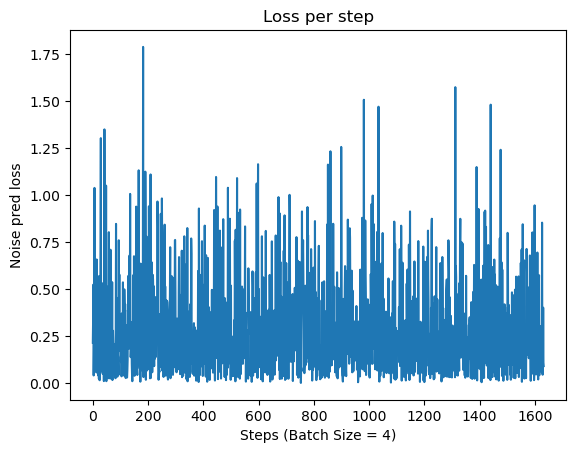

In [ ]:
import matplotlib.pyplot as plt

# l = torch.tensor(loss_arr)[:1600].reshape(-1, 10).mean(-1)
plt.plot(loss_arr)
plt.xlabel("Steps (Batch Size = 4)")
plt.ylabel("Noise pred loss")
plt.title("Loss per step")

In [ ]:
torch.save(unet.state_dict(), "unet.pt")
torch.save(encoder_heads.state_dict(), "encoder_heads.pt")

In [ ]:
val_dataset = IMEM(image_transform = image_transform, split='val')

In [ ]:
pipe.generate_language_model(ehs[0:1, ...]).shape

torch.Size([1, 8, 768])

In [ ]:
pipe.encode_prompt('', device, 1, True, prompt_embeds=ehs1[0:1, ...])

AttributeError: 'NoneType' object has no attribute 'to'

In [ ]:

 [x.shape for x in pipe.encode_prompt('', device, 1, True)]

[torch.Size([2, 1, 1024]), torch.Size([2, 1]), torch.Size([2, 8, 768])]

In [ ]:
import numpy as np

image, audio, match_score = val_dataset[0]

with torch.no_grad():
  image = image.unsqueeze(0)
  image = image.to(device)
  emb = image_model(image)

  emb = emb.unsqueeze(1)
  emb = emb.repeat(2, 1, 1)
  ehs, ehs1 = encoder_heads(emb)

  guidance_scale = 3.5
  do_classifier_free_guidance = guidance_scale > 1.0
  num_inference_steps = 200
  audio_length_in_s = 2

  num_channels_latents = unet.config.in_channels
  vocoder_upsample_factor = np.prod(pipe.vocoder.config.upsample_rates) / pipe.vocoder.config.sampling_rate
  height = int(audio_length_in_s / vocoder_upsample_factor)

  shape = (
      1,
      num_channels_latents,
      height // pipe.vae_scale_factor,
      pipe.vocoder.config.model_in_dim // pipe.vae_scale_factor,
  )
  latents =  torch.randn(shape).to(device)

  # scale the initial noise by the standard deviation required by the scheduler
  latents = latents * scheduler.init_noise_sigma

  scheduler.set_timesteps(num_inference_steps, device=device)
  timesteps = scheduler.timesteps
  num_warmup_steps = len(timesteps) - num_inference_steps * scheduler.order
  for i, t in enumerate(tqdm(timesteps)):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    # predict the noise residual
    noise_pred = unet(
        latent_model_input,
        t,
        encoder_hidden_states=ehs,
        encoder_hidden_states_1=ehs1,
        return_dict=False,
    )[0]

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  # 8. Post-processing
  latents = 1 / pipe.vae.config.scaling_factor * latents
  mel_spectrogram = vae.decode(latents).sample
  audio = pipe.mel_spectrogram_to_waveform(mel_spectrogram)

  # audio = audio[:, :original_waveform_length]

  # # 9. Automatic scoring
  # if num_waveforms_per_prompt > 1 and prompt is not None:
  #     audio = self.score_waveforms(
  #         text=prompt,
  #         audio=audio,
  #         num_waveforms_per_prompt=num_waveforms_per_prompt,
  #         device=device,
  #         dtype=prompt_embeds.dtype,
  #     )


C:\Users\Mehnum\scoop\apps\mambaforge\current\envs\CDS\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(
  0%|                                                                                          | 0/200 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (400) must match the size of tensor b (200) at non-singleton dimension 1

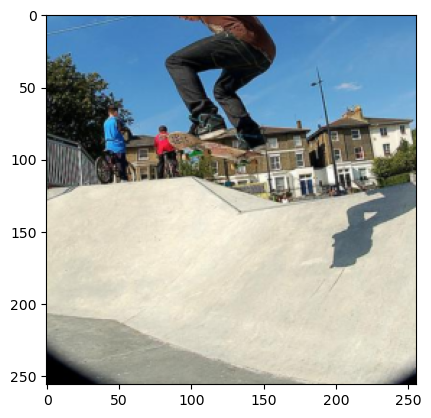

In [ ]:
import IPython.display as PyD
plt.imshow(image.cpu().squeeze(0).movedim(0, -1))
PyD.Audio(audio, rate=16000)